In [31]:
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from typing import List, Tuple
from torch import Tensor
import random
from copy import deepcopy

In [32]:
def load_data(
        n_per_class: int,
        root: str = "../../data/mnist"):
    """

    :param n_per_class:
    :param root:
    :return: out[<train or test>(0,1), <digit>(0,...,9), <data or target>(0,1), batch_dim]
    """
    mnist_train = MNIST(root=root, train=True, download=True)
    mnist_test = MNIST(root=root, train=False, download=True)

    subsets_train = []
    subsets_test = []

    sets = [mnist_train, mnist_test]
    subsets = [subsets_train, subsets_test]
    for digit in range(10):
        for i in range(2):
            cond = sets[i].targets == digit
            data = sets[i].data[cond][:n_per_class].unsqueeze(1).float()
            targets = sets[i].targets[cond][:n_per_class].long()
            subsets[i].append([data, targets])
    return subsets


class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=3,
                kernel_size=3,
                padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(
                in_channels=3,
                out_channels=8,
                kernel_size=3,
                padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(
                in_channels=8,
                out_channels=10,
                kernel_size=7),
            nn.Flatten())
        self.loss = nn.CrossEntropyLoss()

    def forward(self, x: Tensor, y: Tensor):
        scores = self.layers(x)
        loss = self.loss(scores, y)
        return {"loss": loss, "scores": scores}


def acc(scores: Tensor, target: Tensor) -> float:
    preds = torch.argmax(scores, dim=1)
    return ((preds == target).sum() / len(target)).item()

In [33]:
def shuffle(x: Tensor, y: Tensor) -> Tuple[Tensor, Tensor]:
    perm = torch.randperm(x.size(0))
    return x[perm], y[perm]


def sample_tasks(banned_task: Tuple[int, int]) -> Tuple[int, int]:
    while True:
        digit1 = random.randint(a=0, b=9)
        digit2 = random.randint(a=0, b=9)
        if digit1 != digit2:
            if set([digit1, digit2]) != set(banned_task):
                    return digit1, digit2


def reptile_sgd(
        n_iters_outer: int,
        n_iters_inner: int,
        classifier: Classifier,
        lr_inner: float,
        lr_outer: float,
        banned_task: Tuple[int, int],
        data_test: Tuple[Tensor, Tensor],
        data_train: Tuple[Tensor, Tensor]):
    classifier.train()
    learned_tasks = []
    losses_train = []
    accs_train = []
    losses_test = []
    accs_test = []
    num_tasks = len(data_train)
    eval_data_train = torch.cat([data_train[task_id][0] for task_id in range(num_tasks)])
    eval_target_train = torch.cat([data_train[task_id][1] for task_id in range(num_tasks)])

    eval_data_test = torch.cat([data_test[task_id][0] for task_id in range(num_tasks)])
    eval_target_test = torch.cat([data_test[task_id][1] for task_id in range(num_tasks)])

    for i in range(n_iters_outer):
        if (i + 1) % 50 == 0:
            print("iteration", i + 1)
        classifier_inner = deepcopy(classifier)

        task1, task2 = sample_tasks(banned_task=banned_task)
        learned_tasks.append(set((task1, task2)))
        data = torch.cat([data_train[task1][0], data_train[task2][0]])
        target = torch.cat([data_train[task1][1], data_train[task2][1]])
        data, target = shuffle(x=data, y=target)
        for j in range(n_iters_inner):
            classifier_inner.zero_grad()
            loss = classifier_inner(x=data, y=target)["loss"]
            for param in classifier_inner.parameters():
                grad = torch.autograd.grad(loss, param, create_graph=True)[0]
                param.data.sub_(lr_inner * grad)

        params_inner = []
        for param_inner in classifier_inner.parameters():
            params_inner.append(param_inner)

        for j, param_outer in enumerate(classifier.parameters()):
            param_outer.data.sub_(lr_outer * (param_outer + params_inner[j]))

        # evaluation
        with torch.no_grad():
            eval_out_train = classifier(x=eval_data_train, y=eval_target_train)
            losses_train.append(eval_out_train["loss"].item())
            accs_train.append(acc(scores=eval_out_train["scores"], target=eval_target_train))

            eval_out_test = classifier(x=eval_data_test, y=eval_target_test)
            losses_test.append(eval_out_test["loss"].item())
            accs_test.append(acc(scores=eval_out_test["scores"], target=eval_target_test))
    return classifier, losses_train, losses_test, accs_train, accs_test, learned_tasks

In [34]:
def evaluate_few_shot(
        cls: Classifier,
        task1: int,
        task2: int,
        lr: float,
        data_train,
        data_test):
    fs_data_train = torch.cat([data_train[task1][0], data_train[task2][0]])
    fs_target_train = torch.cat([data_train[task1][1], data_train[task2][1]])
    fs_data_train, fs_target_train = shuffle(x=fs_data_train, y=fs_target_train)

    fs_data_test = torch.cat([data_test[task1][0], data_test[task2][0]])
    fs_target_test = torch.cat([data_test[task1][1], data_test[task2][1]])
    fs_data_test, fs_target_test = shuffle(x=fs_data_test, y=fs_target_test)

    print("zero shot results:")
    with torch.no_grad():
        scores_train = cls(x=fs_data_train, y=fs_target_train)["scores"]
        scores_test = cls(x=fs_data_test, y=fs_target_test)["scores"]
        print("acc train:", acc(scores=scores_train, target=fs_target_train))
        print("acc test:", acc(scores=scores_test, target=fs_target_test))

    print("\nafter one training step:")
    loss = cls(x=fs_data_train, y=fs_target_train)["loss"]
    for param in cls.parameters():
        grad = torch.autograd.grad(loss, param, create_graph=True)[0]
        param.data.sub_(lr * grad)

    with torch.no_grad():
        scores_train = cls(x=fs_data_train, y=fs_target_train)["scores"]
        scores_test = cls(x=fs_data_test, y=fs_target_test)["scores"]
        print("acc train:", acc(scores=scores_train, target=fs_target_train))
        print("acc test:", acc(scores=scores_test, target=fs_target_test))

In [35]:
n_samples_per_class = 200
n_iters_outer = 500
n_iters_inner = 10
data_train, data_test = load_data(n_per_class=n_samples_per_class)
lr_inner = 0.0003
lr_outer = 1
banned_task = (8, 9)

iteration 50
iteration 100
iteration 150
iteration 200
iteration 250
iteration 300
iteration 350
iteration 400
iteration 450
iteration 500


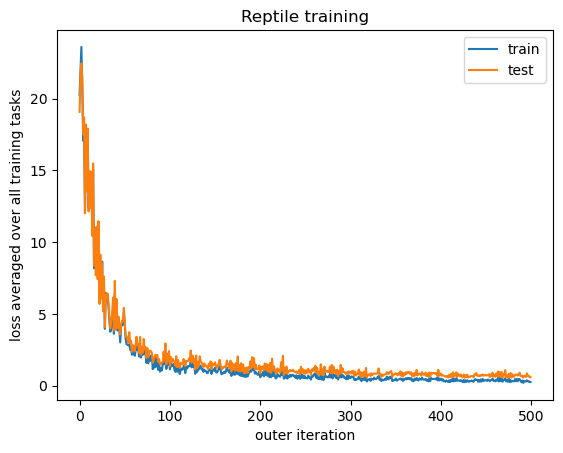

In [36]:
classifier = Classifier()
classifier_init = deepcopy(classifier)  # for baseline later on

classifier_pretrained, losses_train, losses_test, accs_train, accs_test, learned_tasks = reptile_sgd(
    n_iters_outer=n_iters_outer,
    n_iters_inner=n_iters_inner,
    classifier=classifier,
    data_train=data_train,
    data_test=data_test,
    banned_task=banned_task,
    lr_inner=lr_inner,
    lr_outer=lr_outer)

plt.plot(range(len(losses_train)), losses_train, label="train")
plt.plot(range(len(losses_test)), losses_test, label="test")
plt.xlabel("outer iteration")
plt.ylabel("loss averaged over all training tasks")
plt.title("Reptile training")
plt.legend()
plt.show()

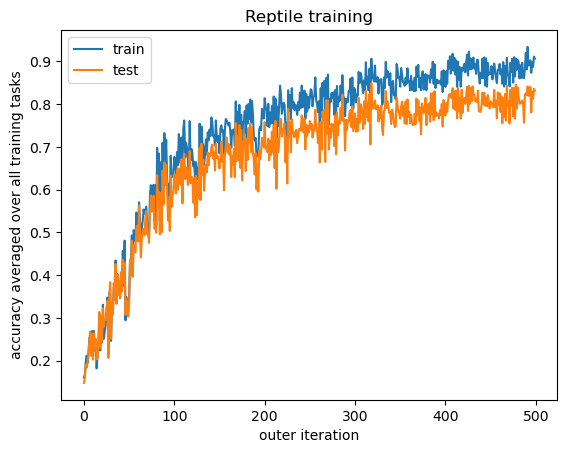

In [37]:
plt.plot(range(len(accs_train)), accs_train, label="train")
plt.plot(range(len(accs_test)), accs_test, label="test")
plt.xlabel("outer iteration")
plt.ylabel("accuracy averaged over all training tasks")
plt.title("Reptile training")
plt.legend()
plt.show()

# fine tuning to a seen task with just one update step
- almost perfect scores after just one fine tune update step

In [38]:
task1, task2 = (1, 7)
print(f"task '{task1} vs {task2}' was trained", learned_tasks.count(set((task1, task2))), "times in reptile")
evaluate_few_shot(
    cls=deepcopy(classifier_pretrained),
    task1=task1,
    task2=task2,
    data_train=data_train,
    data_test=data_test,
    lr=lr_inner)

task '1 vs 7' was trained 12 times in reptile
zero shot results:
acc train: 0.9725000262260437
acc test: 0.9350000023841858

after one training step:
acc train: 0.9850000143051147
acc test: 0.9399999976158142


# few shot training on a new task on seen data
- model never *directly* distinguished 8 vs 9, so the zero shot accuracy is bad
- a single update step leads to huge improvement

In [39]:
task1, task2 = banned_task
print(f"task '{task1} vs {task2}' was trained", learned_tasks.count(set((task1, task2))), "times in reptile")
evaluate_few_shot(
    cls=deepcopy(classifier_pretrained),
    task1=task1,
    task2=task2,
    data_train=data_train,
    data_test=data_test,
    lr=lr_inner)

task '8 vs 9' was trained 0 times in reptile
zero shot results:
acc train: 0.7825000286102295
acc test: 0.6875

after one training step:
acc train: 0.9275000095367432
acc test: 0.8399999737739563


# training from scratch as baseline
- few shot results from a randomly initialized network (no reptile)

In [40]:
evaluate_few_shot(
    cls=classifier_init,
    task1=banned_task[0],
    task2=banned_task[1],
    data_train=data_train,
    data_test=data_test,
    lr=lr_inner)

zero shot results:
acc train: 0.1274999976158142
acc test: 0.03999999910593033

after one training step:
acc train: 0.41749998927116394
acc test: 0.3075000047683716


\begin{tabular}{ccc}
& \text{seen data, seen task} & \text{seen data, new task} & \text{new data, new task}\\
\hline
\text{test accuracy one shot after init} & & & \bf{0.31} \\
\text{test accuracy after reptile} & 0.94 & 0.69 \\
\text{test accuracy one shot after reptile} & 0.94 & \bf{0.84} \\
\end{tabular}

# cocnlusions
- zero shot results on a task used in reptile close to perfect
- reptile improves one shot results (0.31 acc without reptile pretraining, 0.84 acc with reptile pretraining)